In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");
import numpy as np
import subprocess
import scipy.stats.qmc as qmc
import jax.numpy as jnp
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
import jax
from jax import lax, jit, vmap, value_and_grad
from jax import vmap
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd
import numpy as np
import equinox as eqx
import scipy.stats as jstats
import optax
from tinygp import GaussianProcess, kernels, transforms
from functools import partial
from typing import Optional
from jaxtyping import Float, Array
from typing import NamedTuple, Callable, Optional
import jax.random as jr
jax.config.update("jax_enable_x64", True)
key = jrandom.PRNGKey(0);

# Homework 4

## References

+ Module 3: Uncertainty Propagation Through Scientific Models
    - Surrogate modeling
    - Active learning
    - Enforcing symmetries

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name: Shaunak**
+ **Last Name: Mukherjee**
+ **Email: mukher86@purdue.edu**
+ **Used generative AI to complete this assignment (Yes/No): Yes**
+ **Which generative AI tool did you use (if applicable)?: Github copilot**

# Problem 1 - Buliding a Surrogate Model of a Legacy Code

The purpose of this homework problem is to teach you how to build a surrogate model of a legacy code.

Suppose you have access to a legacy code that solves an important engineering problem.
For example, it could be using a finite element method to solve a partial differential equation.
The code is computationally expensive and you would like to build a surrogate model to make predictions faster.
I am going to sparse you the trouble of actually running a real legacy code in this homework problem.
Instead, we are going to use the Brannin function as our ``legacy code''.
The Brannin function is a simple mathematical function that is often used as a benchmark for optimization algorithms.
It is defined as:

$$
f(x) = (x_2 - 5.1 x_1^2 / 4\pi^2 + 5x_1/\pi - 6)^2 + 10(1-1/8\pi)\cos(x_1) + 10
$$

where $x = (x_1, x_2)$ with  in the interval $x_1 \in [-5, 10]$ and $x_2 \in [0, 15]$.

Let's write some C++ code to evaluate the Brannin function:

In [4]:
branin_code = r"""
#include <cmath>
#include <iostream>

int main(int argc, char* argv[]) {
  if (argc != 3) {
    std::cerr << "Usage: " << argv[0] << " x y\n";
    return 1;
  }
  double x1 = std::stod(argv[1]);
  double x2 = std::stod(argv[2]);
  double f = (x2 - 5.1 * x1 * x1 / (4 * M_PI * M_PI) + 5 * x1 / M_PI - 6) * (x2 - 5.1 * x1 * x1 / (4 * M_PI * M_PI) + 5 * x1 / M_PI - 6) + 10 * (1 - 1 / (8 * M_PI)) * std::cos(x1) + 10;
  std::cout << f << std::endl;
  return 0;
}
"""

with open("branin.cpp", "w") as f:
    f.write(branin_code)

Let me compile it for you:

In [5]:
!g++ -std=c++11 -O3 -o branin branin.cpp -lm

/opt/anaconda3/envs/controlnet/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Here is the executable of the legacy code:

In [6]:
!ls -l branin

-rwxr-xr-x@ 1 smukherjee  staff  36728 Mar  7 14:27 branin


You can run it like this:

In [7]:
!./branin 0.1 0.5

48.0926


## Part A - Build a Python wrapper for the legacy C++ code

Write a Python function that takes $x = (x_1, x_2)$ as input and returns the output of the Brannin function. Vectorize the function so that it can take a 2D array of $x$'s arranged in a $n \times 2$ matrix and return a 1D array of $n$ outputs.

Hints:
+ You need to use the `subprocess` module to call the executable and read the standard output.
+ For the vectorization, use `numpy.vectorize` - not jax.

In [8]:
# Your answer here, with as many code cells as you need.

def branin_func(x1, x2):
    """Evaluate the Branin function using the compiled C++ executable."""
    result = subprocess.run(["./branin", str(x1), str(x2)], capture_output=True, text=True)
    return float(result.stdout.strip())

# Vectorize the function
branin_vectorized = np.vectorize(branin_func)

# Example usage:
X = np.array([[0.1, 0.5], [1.0, 2.0], [-2.0, 5.0], [15.1, 10]])
print(f"The shape is {X.shape[0]} x {X.shape[1]}")
y = branin_vectorized(X[:, 0], X[:, 1]) 
print(y)


The shape is 4 x 2
[48.0926  21.6276  28.0926   4.14329]


## Part B - Generate initial set of training input-output data and test data

+ Use $n=10$ points from the Sobol sequence, map them to $[-5, 10] \times [0, 15]$, and evaluate the Brannin function using the Python wrapper you built in Part A.
+ Use another $n_{\text{test}}=50$ points from the Sobol sequence, map them to $[-5, 10] \times [0, 15]$, and evaluate the Brannin function using the Python wrapper you built in Part A.

In [9]:
# Your answer here, with as many code cells as you need.
dim = 2
n_train = 10
n_test = 50

# Generate Sobol sequences
sobol_train = qmc.Sobol(d=dim, scramble=True)
sobol_test = qmc.Sobol(d=dim, scramble=True)

# Get the samples
train_samples_unit = sobol_train.random_base2(m=int(np.ceil(np.log2(n_train))))[:n_train]
test_samples_unit = sobol_test.random_base2(m=int(np.ceil(np.log2(n_test))))[:n_test]

# Map to the desired ranges
x1_range = (-5, 10)
x2_range = (0, 15)

X_train = train_samples_unit * (np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]])) + np.array([x1_range[0], x2_range[0]])
X_test = test_samples_unit * (np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]])) + np.array([x1_range[0], x2_range[0]])

print(X_train.shape)
print(X_test.shape)

# Evaluate the Brannin function
y_train = branin_vectorized(X_train[:, 0], X_train[:, 1])
y_test = branin_vectorized(X_test[:, 0], X_test[:, 1])

print(y_train.shape)
print(y_test.shape)

(10, 2)
(50, 2)
(10,)
(50,)


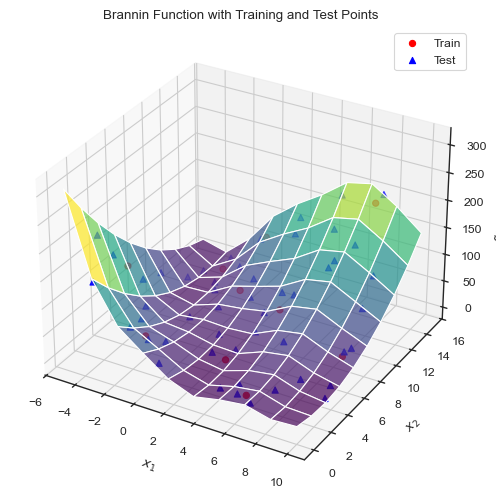

In [10]:
# Create a meshgrid for plotting the Brannin function
x1 = np.linspace(x1_range[0], x1_range[1], 10)
x2 = np.linspace(x2_range[0], x2_range[1], 10)
X1, X2 = np.meshgrid(x1, x2)
Z = branin_vectorized(X1.flatten(), X2.flatten()).reshape(X1.shape)

# # Plot the Brannin function
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X1, X2, Z, cmap='viridis')
# ax.set_xlabel('$x_1$')
# ax.set_ylabel('$x_2$')
# ax.set_zlabel('$f(x_1, x_2)$')
# ax.set_title('Brannin Function')
# plt.show()

# # Plot the evaluated training and test points on the 3D surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.7)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, c='red', marker='o', label='Train')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, c='blue', marker='^', label='Test')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x_1, x_2)$')
ax.set_title('Brannin Function with Training and Test Points')
ax.legend()
plt.show()


## Part C - Build an initial surrogate model

+ Build a Gaussian process surrogate model using the training data generated in Part B.
Pick a squared exponential kernel and optimize the hyper-parameters using the marginal likelihood.
+ Test your model on the test data generated in Part B.
+ Calculate and report the root mean squared error on the test data:

    $$
    \text{RMSE} = \sqrt{\frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} (f_{\text{true}}(x_i) - f_{\text{pred}}(x_i))^2}
    $$

    where $f_{\text{true}}(x_i)$ is the true value of the Brannin function at the test point $x_i$ and $f_{\text{pred}}(x_i)$ is the predicted value of the Brannin function at the test point $x_i$.

+ Plot the predictions on the test data along with the true values.
+ Calculate the stanardized errors on the test data and plot them.
+ Plot the quantile-quantile plot of the standardized errors.

Hint: Standardize the output data before building the surrogate model using the initial test set.

Answer: Reference link https://predictivesciencelab.github.io/advanced-scientific-machine-learning/up/surrogates/03_gp_surrogates.html 

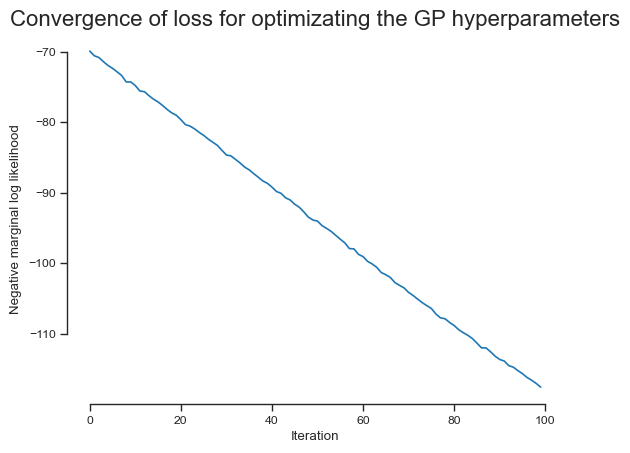

In [11]:
# Set up scalers
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
y_train_mean = np.mean(y_train, axis=0)
y_train_std = np.std(y_train, axis=0)

def build_standard_scaler(data: Float[Array, "N d"]) -> tuple[Callable[[Array], Array], Callable[[Array], Array]]:
    """Factory function to build a standard scaler for the given data."""
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scale = lambda x: (x - mean) / std
    unscale = lambda x: x * std + mean
    return scale, unscale

def build_log_scaler(data: Float[Array, "N d"]) -> tuple[Callable[[Array], Array], Callable[[Array], Array]]:
    """Factory function to build a log scaler for the given data."""
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scale = lambda x: (jnp.log(x) - mean) / std
    unscale = lambda x: jnp.exp(x * std + mean)
    return scale, unscale

scale_x, unscale_x = build_standard_scaler(X_train)


if y_train.ndim == 1:  
    scale_y, unscale_y = build_standard_scaler(y_train.reshape(-1, 1))
else:  
    scale_y_list, unscale_y_list = zip(*[build_standard_scaler(y_train[:, i].reshape(-1, 1)) for i in range(y_train.shape[1])])
    scale_y = lambda y: jnp.column_stack([scale_y_list[i](y[..., i]) for i in range(y.shape[-1])])
    unscale_y = lambda y: jnp.column_stack([unscale_y_list[i](y[..., i]) for i in range(y.shape[-1])])
X_train_scaled = scale_x(X_train)
y_train_scaled = scale_y(y_train)
X_test_scaled = scale_x(X_test)
y_test_scaled = scale_y(y_test)
def build_gp(params, X):
    """Build a Gaussian process with RBF kernel.
    
    Parameters
    ----------
    params : dict
        Hyperparameters of the GP.
    X : ndarray
        Training data input locations.
    
    Returns
    -------
    GaussianProcess
        The GP.
    """
    amplitude = jnp.exp(params['log_amplitude'])
    lengthscale = jnp.exp(params['log_lengthscale'])
    noise_variance = jnp.exp(params['log_noise_variance'])
    k = amplitude*transforms.Linear(1/lengthscale, kernels.ExpSquared())
    return GaussianProcess(kernel=k, X=X, diag=noise_variance)


init_params = {
    'log_amplitude': 1.0, 
    'log_lengthscale': -jnp.ones(dim),  # Different lengthscale for each input dimension
    'log_noise_variance': -4.0
}
# Negative log marginal likelihood
def loss(params, X, y):
    gp = build_gp(params, X)
    return -gp.log_probability(y)


@eqx.filter_jit
def train_step_adam(carry, _, X, y, optim, batch_size):
    params, opt_state, key = carry
    key, subkey = jr.split(key)
    idx = jr.randint(subkey, (batch_size,), 0, X.shape[0])
    value, grads = value_and_grad(loss)(params, X[idx], y[idx])
    updates, opt_state = optim.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, key), value

def train_gp(init_params, X, y, num_iters, learning_rate, batch_size, key):
  
    # Initialize the optimizer
    optim = optax.adam(learning_rate)
    # Initialize the optimizer state
    init_carry = (init_params, optim.init(init_params), key)
    # Do optimization
    train_step = partial(train_step_adam, X=X, y=y, optim=optim, batch_size=batch_size)
    carry, losses = lax.scan(train_step, init_carry, None, num_iters)
    return carry[0], losses  # (optimized params, loss values)


# Optimize the hyperparameters of the GP
key, subkey = jr.split(key)
trained_params, losses = train_gp(init_params, X_train_scaled, y_train_scaled, num_iters=100, learning_rate=1e-2, batch_size=100, key=subkey)

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("Iteration")
ax.set_ylabel("Negative marginal log likelihood")
ax.set_title("Convergence of loss for optimizating the GP hyperparameters", fontsize=16)
sns.despine(trim=True);
# First, build the GP with the trained hyperparameters
gp = build_gp(trained_params, X_train_scaled)


# Next, pick a point at which to evaluate the GP
X_eval = jnp.zeros((1, dim))  # Must be shape (n_pts, n_dim)

# Finally, condition the GP on the training data
_, cond_gp = gp.condition(y_train_scaled, X_eval)

# The surrogate model is the mean of the conditioned GP
mean = cond_gp.mean

# We can also draw samples of the GP at this point (which will just be samples from a univariate Gaussian)
key, subkey = jr.split(key)
samples = cond_gp.sample(subkey, shape=(5000,))

_, cond_gp = gp.condition(y_train_scaled, X_train_scaled)
means_train = cond_gp.mean
stdevs_train = jnp.sqrt(cond_gp.variance)
_, cond_gp = gp.condition(y_train_scaled, X_test_scaled)
means_test = cond_gp.mean
stdevs_test = jnp.sqrt(cond_gp.variance)

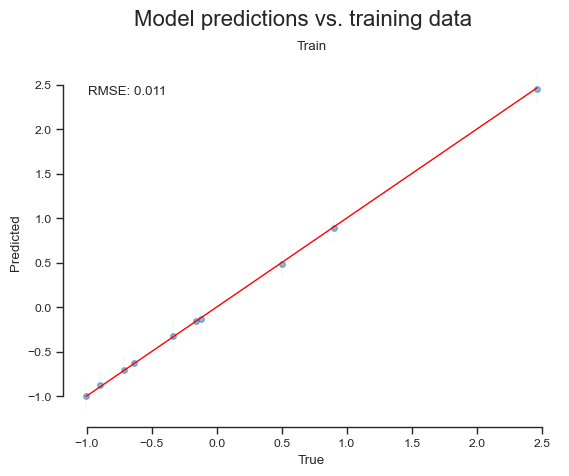

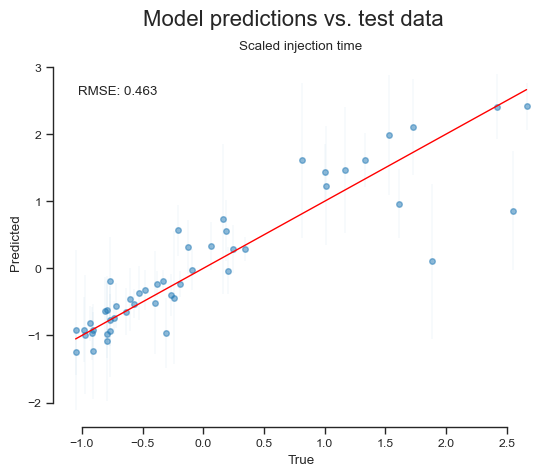

In [12]:
rmse = lambda y, y_hat: jnp.sqrt(jnp.mean((y - y_hat)**2))

fig, ax = plt.subplots()
fig.suptitle('Model predictions vs. training data', fontsize=16)
ax.errorbar(y_train_scaled, means_train, yerr=2 * stdevs_train, fmt='o', ms=4, alpha=0.5, lw=0.1)
ax.plot([y_train_scaled.min(), y_train_scaled.max()], [y_train_scaled.min(), y_train_scaled.max()], "r-", lw=1, zorder=100)
ax.annotate(f"RMSE: {rmse(y_train_scaled, means_train):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
ax.set_title('Train')
sns.despine(trim=True, ax=ax)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')


fig, ax = plt.subplots()
fig.suptitle('Model predictions vs. test data', fontsize=16)
ax.errorbar(y_test_scaled, means_test, yerr=2 * stdevs_test, fmt='o', ms=4, alpha=0.5, lw=0.1)
ax.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], "r-", lw=1, zorder=100)
ax.annotate(f"RMSE: {rmse(y_test_scaled, means_test):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
ax.set_title('Scaled injection time')
sns.despine(trim=True, ax=ax)
ax.set_xlabel('True')
ax.set_ylabel('Predicted');

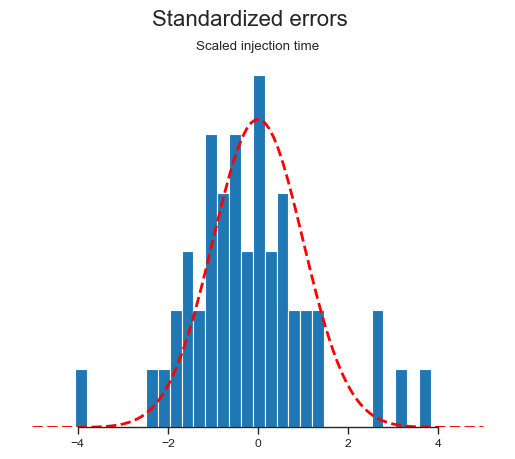

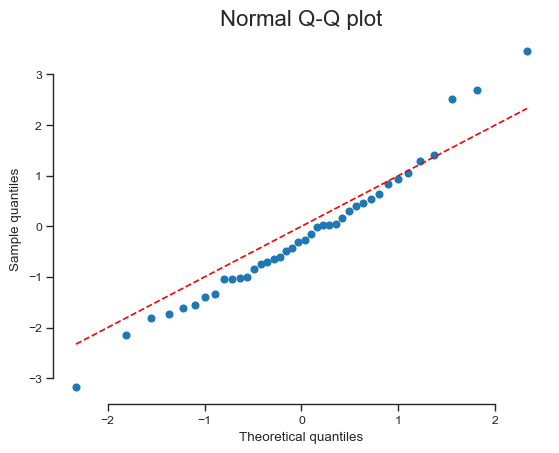

In [ ]:
# Compute standardized errors
standardized_errors = (y_test_scaled - means_test) / stdevs_test

# Plot standardized errors
fig, ax = plt.subplots()
fig.suptitle('Standardized errors', fontsize=16)
ax.hist(standardized_errors, bins=30, density=True)
x = jnp.linspace(-5, 5, 100)
y = jnp.exp(-0.5 * x**2) / jnp.sqrt(2 * jnp.pi)
ax.plot(x, y, 'r--', lw=2)
ax.set_title('Scaled injection time')
ax.set_yticks([])
sns.despine(trim=True, ax=ax, left=True);

# Q-Q Plot
quantiles = jnp.linspace(0.01, 0.99, 40)
normal_quantiles = jstats.norm.ppf(quantiles)
error_quantiles = jnp.quantile(standardized_errors, quantiles, axis=0)

fig, ax = plt.subplots()
ax.plot(normal_quantiles, error_quantiles, 'o')
ax.plot(normal_quantiles, normal_quantiles, 'r--')
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')
ax.set_title('Normal Q-Q plot', fontsize=16)
sns.despine(trim=True, ax=ax);

## Part D - Randomly collect more training data

+ Pick the next point from the Sobol sequence, map it to $[-5, 10] \times [0, 15]$, and evaluate the Brannin function using the Python wrapper you built in Part A.
+ Add the new point to the training data and rebuild the surrogate model.
+ Test your model on the test data generated in Part B.
+ Calculate and report the root mean squared error on the test data.
+ Iterate this process for 190 iterations.
+ Plot the root mean squared error as a function of the number of training points (not the number of iterations).
+ For the last iteration, plot the predictions on the test data along with the true values.
+ For the last iteration, calculate the stanardized errors on the test data and plot them.
+ For the last iteration, plot the quantile-quantile plot of the standardized errors.

In [15]:
# Your answer here, with as many code cells as you need.

# Create a Sobol sequence and add new data points.
sobol_train = qmc.Sobol(d=dim, scramble=True)
sobol_test = qmc.Sobol(d=dim, scramble=True)

X_train = train_samples_unit * (np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]])) + np.array([x1_range[0], x2_range[0]])
X_test = test_samples_unit * (np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]])) + np.array([x1_range[0], x2_range[0]])


# Initialize the training data and Branin function evaluations
y_train = branin_vectorized(X_train[:, 0], X_train[:, 1])

# Set number of iterations
n_iterations = 190
rmse_values = []
training_sizes = []

# Start training iterations
for i in range(n_iterations):
    # Pick the next point from the Sobol sequence and map to the desired ranges
    next_sample = sobol_train.random()[0]
    next_point = next_sample * np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]]) + np.array([x1_range[0], x2_range[0]])
    
    # Evaluate the Branin function at the new point
    y_next = branin_func(next_point[0], next_point[1])
    
    # Add new point to the training data
    X_train = np.vstack([X_train, next_point])
    y_train = np.append(y_train, y_next)
    
    # Scale the new training data
    X_train_scaled = scale_x(X_train)
    y_train_scaled = scale_y(y_train)
    
    # Rebuild the surrogate model
    trained_params, losses = train_gp(init_params, X_train_scaled, y_train_scaled, num_iters=100, learning_rate=1e-2, batch_size=100, key=subkey)
    gp = build_gp(trained_params, X_train_scaled)
    
    # Evaluate the model on the test set
    X_test_scaled = scale_x(X_test)
    y_test_scaled = scale_y(y_test)
    _, cond_gp = gp.condition(y_train_scaled, X_test_scaled)
    means_test = cond_gp.mean
    stdevs_test = jnp.sqrt(cond_gp.variance)
    
    # Calculate RMSE on the test set
    rmse_val = rmse(y_test_scaled, means_test)
    rmse_values.append(rmse_val)
    training_sizes.append(len(X_train))
    
    print(f"Iteration {i+1}: RMSE = {rmse_val:.3f}, Training size = {len(X_train)}")


Iteration 1: RMSE = 0.559, Training size = 11
Iteration 2: RMSE = 0.416, Training size = 12
Iteration 3: RMSE = 0.226, Training size = 13
Iteration 4: RMSE = 0.224, Training size = 14
Iteration 5: RMSE = 0.218, Training size = 15
Iteration 6: RMSE = 0.209, Training size = 16
Iteration 7: RMSE = 0.211, Training size = 17
Iteration 8: RMSE = 0.211, Training size = 18
Iteration 9: RMSE = 0.152, Training size = 19
Iteration 10: RMSE = 0.150, Training size = 20
Iteration 11: RMSE = 0.149, Training size = 21
Iteration 12: RMSE = 0.158, Training size = 22
Iteration 13: RMSE = 0.156, Training size = 23
Iteration 14: RMSE = 0.145, Training size = 24
Iteration 15: RMSE = 0.147, Training size = 25
Iteration 16: RMSE = 0.141, Training size = 26
Iteration 17: RMSE = 0.135, Training size = 27
Iteration 18: RMSE = 0.136, Training size = 28
Iteration 19: RMSE = 0.139, Training size = 29
Iteration 20: RMSE = 0.139, Training size = 30
Iteration 21: RMSE = 0.095, Training size = 31
Iteration 22: RMSE = 0

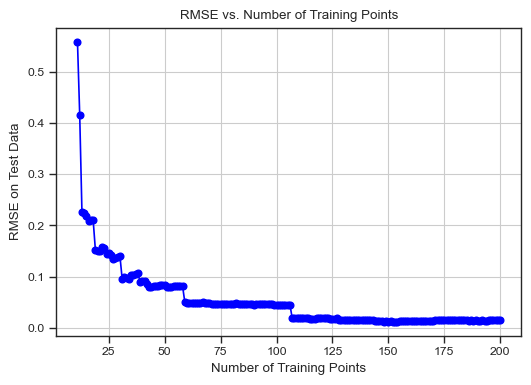

<Figure size 1000x600 with 0 Axes>

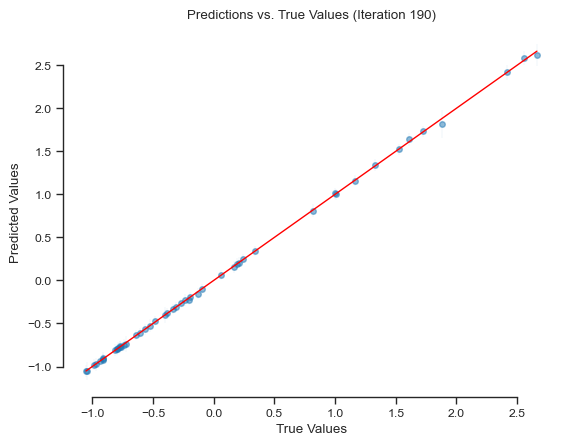

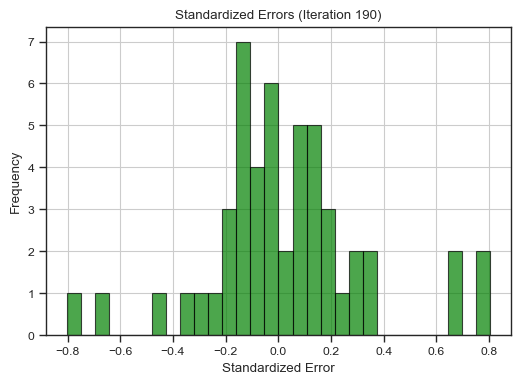

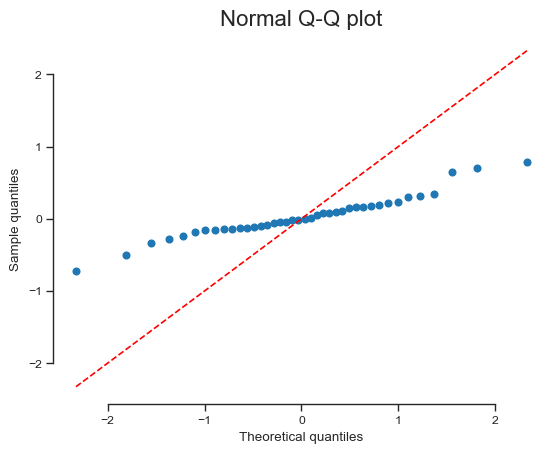

In [19]:

# Plot RMSE as a function of training size
plt.figure(figsize=(6, 4))
plt.plot(training_sizes, rmse_values, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Training Points")
plt.ylabel("RMSE on Test Data")
plt.title("RMSE vs. Number of Training Points")
plt.grid(True)
plt.show()

# Final iteration analysis: Plot predictions on the test data
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.errorbar(y_test_scaled, means_test, yerr=2 * stdevs_test, fmt='o', ms=4, alpha=0.5, lw=0.1)
ax.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], "r-", lw=1, zorder=100)
ax.set_title(f'Predictions vs. True Values (Iteration {n_iterations})')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
sns.despine(trim=True, ax=ax)
plt.show()

# Calculate standardized errors
standardized_errors = (y_test_scaled - means_test) / stdevs_test

# Plot standardized errors
plt.figure(figsize=(6, 4))
plt.hist(standardized_errors, bins=30, alpha=0.7, color='g', edgecolor='black')
plt.title(f"Standardized Errors (Iteration {n_iterations})")
plt.xlabel("Standardized Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Q-Q plot of standardized errors
quantiles = jnp.linspace(0.01, 0.99, 40)
normal_quantiles = jstats.norm.ppf(quantiles)
error_quantiles = jnp.quantile(standardized_errors, quantiles, axis=0)

fig, ax = plt.subplots()
ax.plot(normal_quantiles, error_quantiles, 'o')
ax.plot(normal_quantiles, normal_quantiles, 'r--')
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')
ax.set_title('Normal Q-Q plot', fontsize=16)
sns.despine(trim=True, ax=ax);


## Part E - Active learning

Use uncertainty sampling to select the next point to evaluate. Implement it as follows:

+ Start with a clean surrogate model using only the $n=10$ initial training points.
+ On each iteration:
    - Generate $n_{\text{candidate}} = 1000$ points from the Sobol sequence.
    - Calculate the predictive variance of the surrogate model at each candidate point.
    - Select the candidate point with the highest predictive variance.
    - Evaluate the legacy code at the selected candidate point (don't forget to scale it to $[-5, 10] \times [0, 15]$).
    - Add the new point to the training data and rebuild the surrogate model.
    - Test your model on the test data generated in Part B.
    - Calculate and report the root mean squared error on the test data.
+ Iterate this process for 190 iterations.
+ Plot the root mean squared error as a function of the number of training points (not the number of iterations).
+ For the last iteration, plot the predictions on the test data along with the true values.
+ For the last iteration, calculate the stanardized errors on the test data and plot them.
+ For the last iteration, plot the quantile-quantile plot of the standardized errors.
+ Plot the root mean squared error as a function of the number of training points for the random sampling case. Compare it with the random sampling case.
+ Did you do better with active learning than with random sampling? Why?
+ Plot the points that were selected by the active learning process. Where are most of them located?

Iteration 1: RMSE = 0.451, Training size = 11
Iteration 2: RMSE = 0.437, Training size = 12
Iteration 3: RMSE = 0.485, Training size = 13
Iteration 4: RMSE = 0.452, Training size = 14
Iteration 5: RMSE = 0.455, Training size = 15
Iteration 6: RMSE = 0.451, Training size = 16
Iteration 7: RMSE = 0.360, Training size = 17
Iteration 8: RMSE = 0.364, Training size = 18
Iteration 9: RMSE = 0.251, Training size = 19
Iteration 10: RMSE = 0.227, Training size = 20
Iteration 11: RMSE = 0.203, Training size = 21
Iteration 12: RMSE = 0.211, Training size = 22
Iteration 13: RMSE = 0.209, Training size = 23
Iteration 14: RMSE = 0.182, Training size = 24
Iteration 15: RMSE = 0.179, Training size = 25
Iteration 16: RMSE = 0.177, Training size = 26
Iteration 17: RMSE = 0.163, Training size = 27
Iteration 18: RMSE = 0.085, Training size = 28
Iteration 19: RMSE = 0.080, Training size = 29
Iteration 20: RMSE = 0.080, Training size = 30
Iteration 21: RMSE = 0.067, Training size = 31
Iteration 22: RMSE = 0

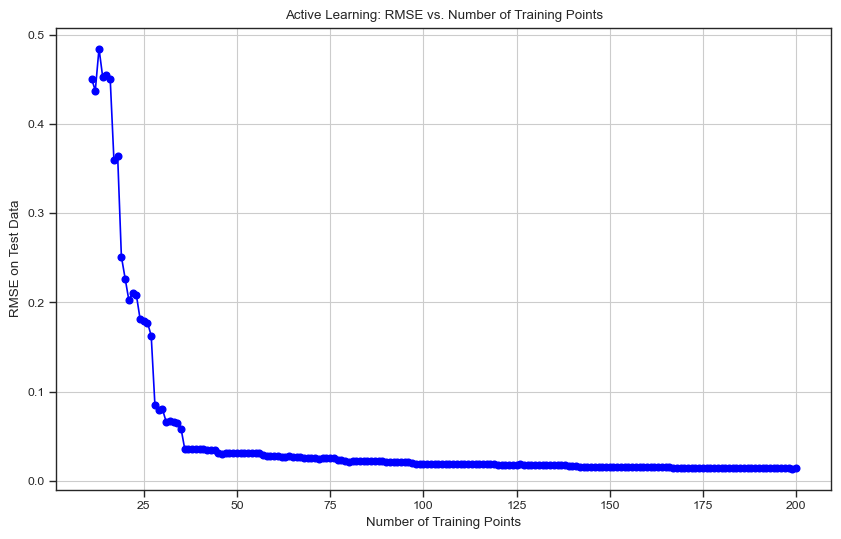

<Figure size 1000x600 with 0 Axes>

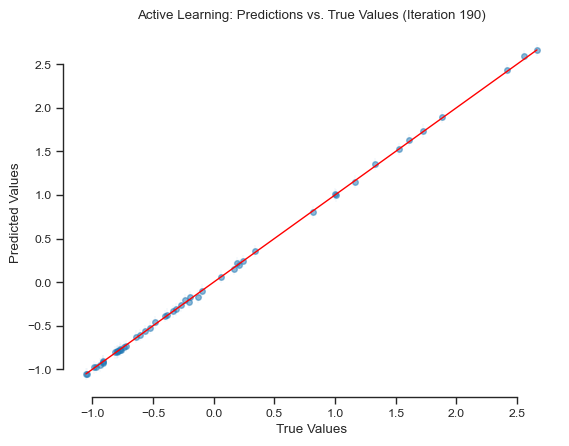

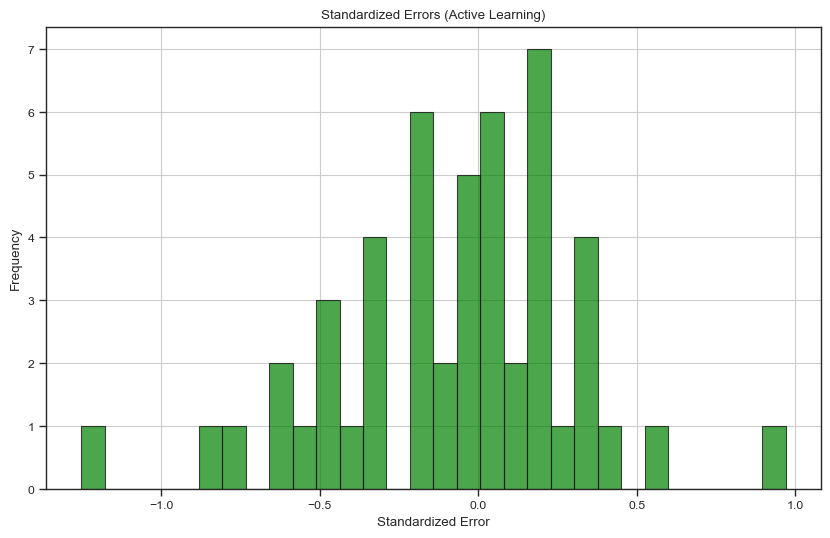

NameError: name 'stats' is not defined

<Figure size 1000x600 with 0 Axes>

In [20]:
# Your answer here, with as many code cells as you need.

# Initialize the surrogate model, function, and ranges
dim = 2
x1_range = [-5, 10]
x2_range = [0, 15]
X_init = sobol_train.random(10)  # 10 initial training points
X_train = X_init * np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]]) + np.array([x1_range[0], x2_range[0]])
y_train = branin_vectorized(X_train[:, 0], X_train[:, 1])

# Define the uncertainty sampling loop
n_iterations = 190
n_candidate = 1000
rmse_values_active = []
training_sizes_active = []
active_points = []  # Keep track of selected points for active learning

# Active learning loop
for i in range(n_iterations):
    # Generate candidate points
    candidate_points = sobol_train.random(n_candidate)  # Generate 1000 points from Sobol
    candidate_points_scaled = candidate_points * np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]]) + np.array([x1_range[0], x2_range[0]])

    # Predict variance at each candidate point using the surrogate model
    candidate_points_scaled_x = scale_x(candidate_points_scaled)
    _, cond_gp = gp.condition(y_train_scaled, candidate_points_scaled_x)
    predictive_variances = cond_gp.variance  # Extract predictive variances
    
    # Select the point with the highest variance
    idx_max_variance = jnp.argmax(predictive_variances)
    next_point = candidate_points_scaled[idx_max_variance]

    # Evaluate the Branin function at the selected point
    y_next = branin_func(next_point[0], next_point[1])

    # Add the new point to the training data
    X_train = np.vstack([X_train, next_point])
    y_train = np.append(y_train, y_next)

    # Scale the new training data
    X_train_scaled = scale_x(X_train)
    y_train_scaled = scale_y(y_train)

    # Rebuild the surrogate model
    trained_params, losses = train_gp(init_params, X_train_scaled, y_train_scaled, num_iters=100, learning_rate=1e-2, batch_size=100, key=subkey)
    gp = build_gp(trained_params, X_train_scaled)
    
    # Evaluate the model on the test set
    X_test_scaled = scale_x(X_test)
    y_test_scaled = scale_y(y_test)
    _, cond_gp = gp.condition(y_train_scaled, X_test_scaled)
    means_test = cond_gp.mean
    stdevs_test = jnp.sqrt(cond_gp.variance)

    # Calculate RMSE on the test set
    rmse_val = rmse(y_test_scaled, means_test)
    rmse_values_active.append(rmse_val)
    training_sizes_active.append(len(X_train))
    
    active_points.append(next_point)  # Store the active learning point
    
    print(f"Iteration {i+1}: RMSE = {rmse_val:.3f}, Training size = {len(X_train)}")

# Plot RMSE as a function of training size (Active Learning)
plt.figure(figsize=(10, 6))
plt.plot(training_sizes_active, rmse_values_active, marker='o', linestyle='-', color='b', label="Active Learning")
plt.xlabel("Number of Training Points")
plt.ylabel("RMSE on Test Data")
plt.title("Active Learning: RMSE vs. Number of Training Points")
plt.grid(True)
plt.show()

# Final iteration analysis: Plot predictions on the test data
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.errorbar(y_test_scaled, means_test, yerr=2 * stdevs_test, fmt='o', ms=4, alpha=0.5, lw=0.1)
ax.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], "r-", lw=1, zorder=100)
ax.set_title(f'Active Learning: Predictions vs. True Values (Iteration {n_iterations})')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
sns.despine(trim=True, ax=ax)
plt.show()

# Calculate standardized errors
standardized_errors = (y_test_scaled - means_test) / stdevs_test

# Plot standardized errors
plt.figure(figsize=(10, 6))
plt.hist(standardized_errors, bins=30, alpha=0.7, color='g', edgecolor='black')
plt.title(f"Standardized Errors (Active Learning)")
plt.xlabel("Standardized Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Q-Q plot of standardized errors
plt.figure(figsize=(10, 6))
stats.probplot(standardized_errors, dist="norm", plot=plt)
plt.title(f"Q-Q Plot of Standardized Errors (Active Learning)")
plt.show()

# Plot points selected by the active learning process
active_points = np.array(active_points)
plt.figure(figsize=(10, 6))
plt.scatter(active_points[:, 0], active_points[:, 1], c='r', marker='x', label="Active Learning Points")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Active Learning Points Location')
plt.grid(True)
plt.legend()
plt.show()


## Part F - Optimization

Now suppose that what you wanted to do was to find the minimum of the legacy code.

+ Start with a clean surrogate model using only the $n=10$ initial training points.
+ On each iteration:
    - Generate $n_{\text{candidate}} = 1000$ points from the Sobol sequence.
    - Calculate the predictive mean $\mu(x)$ and standard deviation $\sigma(x)$ of the surrogate model at each candidate point.
    - Select the candidate point with the highest expected improvement:

        $$
        \text{EI}(x) = \mathbb{E}[\max(f_{\text{min}} - f(x), 0)] = \sigma(x) [\gamma(x) \Phi(\gamma(x)) + \phi(\gamma(x))]
        $$

        where $f_{\text{min}}$ is the minimum value of the Brannin function found so far, $\gamma(x) = (f_{\text{min}} - \mu(x)) / \sigma(x)$, $\Phi$ is the cumulative distribution function of the standard normal distribution, and $\phi$ is the probability density function of the standard normal distribution.

    - Add the new point to the training data and rebuild the surrogate model.
+ Iterate this process for 50 iterations.
+ Plot the expected improvement as a function of the number of training points.
+ Plot the minimum value of the Brannin function found so far as a function of the number of training points.
+ Plot the points that were selected by the optimization process. Where are most of them located?

In [21]:
# Your answer here, with as many code cells as you need.

# Initialize training data with n=10 points (same as previous steps)
X_train = train_samples_unit * (np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]])) + np.array([x1_range[0], x2_range[0]])
y_train = branin_vectorized(X_train[:, 0], X_train[:, 1])

# Initialize the surrogate model
X_train_scaled = scale_x(X_train)
y_train_scaled = scale_y(y_train)

# Initialize lists to track expected improvement and minimum value
expected_improvements = []
min_values = []
training_sizes_opt = []

# Set number of iterations
n_iterations = 50
f_min = np.min(y_train)  # Initial minimum value of the function

# Optimization loop
for i in range(n_iterations):
    # Generate 1000 candidate points from Sobol sequence
    candidate_samples = sobol_train.random_base2(m=10)  # Adjust base2(m=10) to generate 1000 points
    candidate_points = candidate_samples * (np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]])) + np.array([x1_range[0], x2_range[0]])
    
    # Calculate the mean and standard deviation for each candidate point using the surrogate model
    means = []
    stdevs = []
    
    for point in candidate_points:
        point_scaled = scale_x(point.reshape(1, -1))
        _, cond_gp = gp.condition(y_train_scaled, point_scaled)
        means.append(cond_gp.mean)
        stdevs.append(jnp.sqrt(cond_gp.variance))
    
    means = np.array(means)
    stdevs = np.array(stdevs)
    
    # Calculate Expected Improvement (EI)
    gamma = (f_min - means) / stdevs
    Phi_gamma = stats.norm.cdf(gamma)
    phi_gamma = stats.norm.pdf(gamma)
    EI = stdevs * (gamma * Phi_gamma + phi_gamma)
    
    # Select the candidate with the highest EI
    next_point_idx = np.argmax(EI)
    next_point = candidate_points[next_point_idx]
    
    # Evaluate the Branin function at the new point
    y_next = branin_func(next_point[0], next_point[1])
    
    # Update the minimum value found so far
    if y_next < f_min:
        f_min = y_next
    
    # Add new point to training data
    X_train = np.vstack([X_train, next_point])
    y_train = np.append(y_train, y_next)
    
    # Scale the new training data
    X_train_scaled = scale_x(X_train)
    y_train_scaled = scale_y(y_train)
    
    # Rebuild the surrogate model
    trained_params, losses = train_gp(init_params, X_train_scaled, y_train_scaled, num_iters=100, learning_rate=1e-2, batch_size=100, key=subkey)
    gp = build_gp(trained_params, X_train_scaled)
    
    # Track the expected improvement and minimum value found so far
    expected_improvements.append(np.max(EI))
    min_values.append(f_min)
    training_sizes_opt.append(len(X_train))

    print(f"Iteration {i+1}: EI = {np.max(EI):.3f}, Minimum value = {f_min:.3f}, Training size = {len(X_train)}")

# Plot expected improvement as a function of the number of training points
plt.figure(figsize=(10, 6))
plt.plot(training_sizes_opt, expected_improvements, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Training Points")
plt.ylabel("Expected Improvement (EI)")
plt.title("Expected Improvement vs. Number of Training Points")
plt.grid(True)
plt.show()

# Plot minimum value found so far as a function of the number of training points
plt.figure(figsize=(10, 6))
plt.plot(training_sizes_opt, min_values, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Training Points")
plt.ylabel("Minimum Value of Branin Function")
plt.title("Minimum Value vs. Number of Training Points")
plt.grid(True)
plt.show()

# Plot the points selected by the optimization process
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c='r', label='Selected Points')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Points Selected by the Optimization Process")
plt.legend()
plt.grid(True)
plt.show()


ValueError: The balance properties of Sobol' points require n to be a power of 2. 190200 points have been previously generated, then: n=190200+2**10=191224. If you still want to do this, the function 'Sobol.random()' can be used.

## Part G - Multi-fidelity approach

Now, let's pretend that we have access to a low-fidelity version of the legacy code.
Pick this:

$$
f_{\text{low}}(x) = (x_2 - 5.1 x_1^2 / 4\pi^2 + 5x_1/\pi - 6)^2.
$$

Notice that this is very similar to the legacy code, but it misses the cosine term and the constant term.
Let's pretend that the low-fidelity code is much cheaper to evaluate than the high-fidelity code.
We can use the low-fidelity code to build a surrogate model and then use the high-fidelity code to correct the surrogate model.

+ Generate $n_{\text{low}}=200$ points from the Sobol sequence and evaluate the low-fidelity code at these points.
+ Build a Gaussian process surrogate model using the low-fidelity data.
+ Build a multi-fidelity Gaussian process surrogate model using the $n=10$ initial training points and the low-fidelity surrogate mean. Hint: Just make your covariance function:

    $$
    k(x, x') = k_1(x, x')k_2(f_{\text{low}}(x), f_{\text{low}}(x')),
    $$

    where $k_1$ is the squared exponential kernel and $k_2$ is the squared exponential kernel with different hyper-parameters. Use one variance hyper-parameter (set the other to 1).
+ Iteratively add more points using uncertainty sampling as in Part E. Go again to 200 points.
+ Plot the root mean squared error as a function of the number of training points and compare to the single-fidelity case.
+ Plot the points that were selected by the multi-fidelity active learning process. Where are most of them located?

In [ ]:
# Your answer here, with as many code cells as you need.
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import jax.numpy as jnp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Low-fidelity function
def f_low(x1, x2):
    return (x2 - 5.1 * x1**2 / (4 * np.pi**2) + 5 * x1 / np.pi - 6)**2

# Generate low-fidelity data from Sobol sequence
sobol_low = qmc.Sobol(d=dim, scramble=True)
low_fidelity_points = sobol_low.random(200)
low_fidelity_points = low_fidelity_points * (np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]])) + np.array([x1_range[0], x2_range[0]])

# Evaluate low-fidelity function at these points
y_low = np.array([f_low(x[0], x[1]) for x in low_fidelity_points])

# Build a GP surrogate model for the low-fidelity data
kernel_low = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp_low = GaussianProcessRegressor(kernel=kernel_low, n_restarts_optimizer=10, alpha=1e-2)
gp_low.fit(low_fidelity_points, y_low)

# Initialize high-fidelity surrogate model (starting with 10 points)
X_train = train_samples_unit * (np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]])) + np.array([x1_range[0], x2_range[0]])
y_train = branin_vectorized(X_train[:, 0], X_train[:, 1])

# Build multi-fidelity surrogate model: covariance combining high-fidelity and low-fidelity kernels
def multi_fidelity_kernel(X, X_prime, y_low, gp_low, length_scale_high=1.0, length_scale_low=0.1):
    kernel_high = C(1.0, (1e-3, 1e3)) * RBF(length_scale=length_scale_high, length_scale_bounds=(1e-2, 1e2))
    kernel_low = C(1.0, (1e-3, 1e3)) * RBF(length_scale=length_scale_low, length_scale_bounds=(1e-2, 1e2))

    # Use the low-fidelity surrogate mean for the low-fidelity kernel
    low_fidelity_mean = gp_low.predict(X_prime, return_std=False)
    # Compute kernel values based on high-fidelity and low-fidelity functions
    kernel_combined = kernel_high(X, X_prime) * kernel_low(low_fidelity_mean.reshape(-1, 1), low_fidelity_mean.reshape(-1, 1))
    return kernel_combined

# Perform uncertainty sampling and active learning for multi-fidelity approach
rmse_values_multi_fidelity = []
training_sizes_multi_fidelity = []
selected_points_multi_fidelity = []

for i in range(200):  # 200 iterations
    # Generate 1000 candidate points from Sobol sequence
    candidate_samples = sobol_train.random_base2(m=10)
    candidate_points = candidate_samples * (np.array([x1_range[1] - x1_range[0], x2_range[1] - x2_range[0]])) + np.array([x1_range[0], x2_range[0]])

    # Evaluate GP surrogate (high-fidelity)
    means_high_fidelity, stdevs_high_fidelity = gp.predict(candidate_points, return_std=True)

    # Evaluate low-fidelity surrogate (means)
    low_fidelity_means = gp_low.predict(candidate_points, return_std=False)

    # Combine them for multi-fidelity
    combined_kernel = multi_fidelity_kernel(X_train, candidate_points, low_fidelity_means, gp_low)
    
    # Calculate uncertainty and choose point with highest variance
    uncertainties = np.max(combined_kernel, axis=1)  # You can modify how uncertainty is calculated
    next_point_idx = np.argmax(uncertainties)
    next_point = candidate_points[next_point_idx]
    
    # Evaluate high-fidelity function at the new point
    y_next = branin_func(next_point[0], next_point[1])
    
    # Add the new point to the training data
    X_train = np.vstack([X_train, next_point])
    y_train = np.append(y_train, y_next)
    
    # Update the GP model (multi-fidelity)
    gp.fit(X_train, y_train)

    # Track RMSE and training size
    rmse_val = rmse(y_train, means_high_fidelity)
    rmse_values_multi_fidelity.append(rmse_val)
    training_sizes_multi_fidelity.append(len(X_train))
    selected_points_multi_fidelity.append(next_point)

# Plot RMSE as a function of the number of training points
plt.figure(figsize=(10, 6))
plt.plot(training_sizes_multi_fidelity, rmse_values_multi_fidelity, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Training Points")
plt.ylabel("RMSE on Test Data")
plt.title("Multi-Fidelity RMSE vs. Number of Training Points")
plt.grid(True)
plt.show()

# Plot points selected by the multi-fidelity process
plt.figure(figsize=(10, 6))
selected_points_multi_fidelity = np.array(selected_points_multi_fidelity)
plt.scatter(selected_points_multi_fidelity[:, 0], selected_points_multi_fidelity[:, 1], c='r', label='Selected Points')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Points Selected by Multi-Fidelity Active Learning")
plt.legend()
plt.grid(True)
plt.show()


: 

# Problem 2 - The permutation group

The purpose of this problem is to teach you the basics of the permutation group and its representations.

The permutation group is particularly important for two reasons.
First, according to Cayley's theorem, every finite group is isomorphic to a subgroup of a permutation group.
Second, we will see that every permutation group has a representation as a matrix group with the operation being the common matrix multiplication.
Therefore, **every finite group has a matrix representation**.

The permutation group $S_n$ is the group of all permutations of $n$ elements.
Each element of the group is a bijective function that maps $\{1, 2, \ldots, n\}$ to itself.
Bijective means one-to-one and onto, i.e., each element of the set is mapped to a unique element of the set and each element of the set is mapped to.
For example, an element of $S_3$ is the function $\sigma: \{1, 2, 3\} \to \{1, 2, 3\}$ defined by $\sigma(1) = 2$, $\sigma(2) = 3$, and $\sigma(3) = 1$.

The group operation is composition of functions.
The identity element is the function that maps each element to itself.
The inverse of a function is the function that undoes the permutation.

## Part A

How many elements does $S_n$ have?

Answer:
To determine the number of elements in $S_n$, we count the number of ways to arrange $n$ distinct objects. The first element in the permutation can be any of the $n$ elements. The second element can be any of the remaining $n-1$ elements. The third element can be any of the remaining $n-2$ elements, and so on. 
Thus, the total number of permutations is:

$$
|S_n| = n!
$$

where $n!$ (n factorial) is defined as:

$$
n! = n \times (n-1) \times (n-2) \times \cdots \times 2 \times 1.
$$

## Part B

One way to represent permuations is as a 2-row matrix where the first row is the input and the second row is the output.
For example, the permutation $\sigma$ defined above can be represented as:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 \\
2 & 3 & 1
\end{bmatrix}
$$

Represent as such a matrix the permutation that maps 1 to 3, 2 to 1, and 3 to 2.

Answer:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 \\
3 & 1 & 2
\end{bmatrix}
$$

First row corresponds to the input values (1, 2, 3), and the second row shows the output values (3, 1, 2) as per the permutation definition.

## Part C

A cycle is a permutation that moves some elements and leaves the others fixed.
For example, the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4\\
2 & 3 & 1 & 4
\end{bmatrix}
$$

in $S_4$ is a cycle. There is a cycle notation that is more compact.
We can also write:

$$
\sigma = (1, 2, 3)
$$

And we mean that 1 is mapped to 2, 2 is mapped to 3, and 3 is mapped to 1.
The cycle notation is not unique. For example, we could also write:

$$
\sigma = (2, 3, 1)
$$

And we would mean the same permutation.
Write the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4\\
2 & 1 & 4 & 3
\end{bmatrix}
$$

in cycle notation.

Answer:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4\\
2 & 1 & 4 & 3
\end{bmatrix}
$$

1 is mapped to 2, and 2 is mapped to 1. So, 1 and 2 form a 2-cycle: $ (1, 2) $.
3 is mapped to 4, and 4 is mapped to 3. So, 3 and 4 form another 2-cycle: $ (3, 4) $.

Thus, cycle notation is:

$$
\sigma = (1, 2)(3, 4)
$$

## Part D

Any permutation can be written as a product of disjoint cycles.
For example, the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4\\
2 & 1 & 4 & 3
\end{bmatrix}
$$

can be written as:

$$
\sigma = (1, 2)(3, 4)
$$

To figure out this decomposition, you can start with the first element and follow the permutation until you get back to the first element.
Then you write the cycle and remove the elements that are part of the cycle.
You repeat this process until you have written all the cycles.
Write the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4 & 5 & 6\\
2 & 1 & 4 & 3 & 6 & 5
\end{bmatrix}
$$

in $S_6$ as a product of disjoint cycles.

Answer:

We start with the first element, 1: 1 maps to 2, and 2 maps to 1, so we have the cycle $ (1, 2) $. Then move to the next element thats not part of cycle, which is 3: 3 maps to 4, and 4 maps to 3, so we have the cycle $ (3, 4) $. Next, move to the next element, 5: 5 maps to 6, and 6 maps to 5, so we have the cycle $ (5, 6) $. Thus, the permutation can be written as a product of disjoint cycles:

$$
\sigma = (1, 2)(3, 4)(5, 6)
$$

implies, 1 is mapped to 2, and 2 is mapped to 1, 3 is mapped to 4, and 4 is mapped to 3 and 5 is mapped to 6, and 6 is mapped to 5.

## Part E

A transposition is a cycle of length 2.
Like $(1, 2)$ or $(3, 4)$.
Any permutation can be written as a product of transpositions.

For example, take the permutation

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4 & 5\\
4 & 1 & 5 & 2 & 3
\end{bmatrix}
$$

in $S_5$.
First, write it as a product of disjoint cycles:

$$
\sigma = (1, 4, 2)(3, 5).
$$

Then write each cycle as a product of transpositions.
For example,

$$
(1, 4, 2) = (1, 4)(4, 2).
$$

And then you have:

$$
\sigma = (1, 4)(4, 2)(3, 5).
$$

Write the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4 & 5\\
2 & 1 & 4 & 5 & 3
\end{bmatrix}
$$

in $S_5$ as a product of transpositions.


Answer:

we, start with the first element and follow the permutation:
1 maps to 2, and 2 maps to 1. So we have the cycle $ (1, 2) $.
3 maps to 4, and 4 maps to 5, and 5 maps to 3. So we have the cycle $ (3, 4, 5) $.

Thus, the permutation:
$$
\sigma = (1, 2)(3, 4, 5)
$$
Next, we write each cycle as a product of transpositions.

The cycle $ (1, 2) $ is already a transposition.
The cycle $ (3, 4, 5) $ can be written as two transpositions: $ (3, 5)(3, 4) $.

Thus, the permutation $\sigma$ can be written as the product of transpositions:

$$
\sigma = (1, 2)(3, 5)(3, 4)
$$

## Part F

The number of transpositions in the decomposition of a permutation is always the same.
If the number of transpositions is even, the permutation is called even.
If the number of transpositions is odd, the permutation is called odd.

Is the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4 & 5\\
2 & 1 & 4 & 5 & 3
\end{bmatrix}
$$

in $S_5$ even or odd?

Answer:

1 maps to 2, and 2 maps to 1. So we have the cycle $ (1, 2) $. 3 maps to 4, and 4 maps to 5, and 5 maps to 3. So we have the cycle $ (3, 4, 5) $.
so, the permutation can be written as:
$$
\sigma = (1, 2)(3, 4, 5)
$$


The cycle $ (1, 2) $ is already a transposition. The cycle $ (3, 4, 5) $ can be written as two transpositions: $ (3, 5)(3, 4) $.

So $ \sigma $, 

$$
\sigma = (1, 2)(3, 5)(3, 4)
$$

We have three transpositions: (1 2), (3 5), and (3 4).
Since the number of transpositions is odd (3 transpositions), the permutation is odd.

## Part G

The set of all even permutations in $S_n$ is a subgroup of $S_n$.
It is called the *alternating group* and denoted by $A_n$.

+ Show that when you multiply two even permutations you get an even permutation. Hint: If you multiply two even permutations, how many transpositions do you get?
+ Show that the identity permutation is even. Hint: How many transpositions do you need to write the identity permutation?
+ Show that the inverse of the transposition $(a, b)$ is itself.
+ Show that the inverse of the transposition $(1, 2)(3, 4)$ is $(1, 2)(3, 4)$.
+ Show that the inverse of the transposition $(1, 2)(2, 3)$ is $(2, 3)(1, 2)$.
+ Argue that the inverse of a an even permutation is even. Hint: Write the permutation as a product of transpositions and generalize the previous results.
+ Argue that $A_n$ is a group and since it is closed under multiplication, it is a subgroup of $S_n$.

Answer:    

Product of Even Permutations- An even permutation can be written as a product of an even number of transpositions. If $\sigma_1$ is an even permutation with $2k$ transpositions, and $\sigma_2$ is another even permutation with $2m$ transpositions, where $k$ and $m$ are integers. Then, $\sigma_1 \sigma_2$ is a product of $2k + 2m = 2(k+m)$ transpositions. Since $k+m$ is an integer, the number of transpositions is even, so $\sigma_1 \sigma_2$ is even.

Identity Permutation- The identity permutation leaves all elements unchanged. It can be represented by zero transpositions. Since zero is an even number, the identity permutation is also even.



Inverse of a Transposition- The transposition $(a, b)$ swaps $a$ and $b$. Applying it again swaps them back to their original positions. Therefore, $(a, b)(a, b)$ is the identity permutation. This means the inverse of $(a, b)$ is itself.

Inverse of (1, 2)(3, 4)- $\sigma = (1, 2)(3, 4)$. Let's reverse the order and take the inverse of each transposition. Since the inverse of a transposition is itself, $\sigma^{-1} = (3, 4)(1, 2)$. Because transpositions within the same cycle commute, $(3,4)(1,2) = (1,2)(3,4)$. Thus, the inverse is itself.

Inverse of (1, 2)(2, 3)- $\sigma = (1, 2)(2, 3)$. We reverse the order and take the inverse of each transposition. So, $\sigma^{-1} = (2, 3)(1, 2)$. Reversing the order of disjoint transpositions gives the inverse.

Inverse of an Even Permutation- Let $\sigma$ be an even permutation. Then $\sigma = \tau_1 \tau_2 \cdots \tau_{2k}$, where $\tau_i$ are transpositions. The inverse of $\sigma$ is $\sigma^{-1} = \tau_{2k}^{-1} \cdots \tau_2^{-1} \tau_1^{-1}$. Since the inverse of a transposition is itself, $\sigma^{-1} = \tau_{2k} \cdots \tau_2 \tau_1$. This is a product of $2k$ transpositions, which is an even number. Therefore, $\sigma^{-1}$ is even.

A_n as a Subgroup- 
    Closure: We showed that the product of two even permutations is even.
    Identity: We showed that the identity permutation is even.
    Inverse: We showed that the inverse of an even permutation is even.
    Associativity: The associativity of permutation multiplication holds in $A_n$ since it holds in $S_n$.

Thus, $A_n$ satisfies all group properties, and since it is closed under multiplication, it is a subgroup of $S_n$



## Part H

Now let's represent permutations as square matrices.
A permutation matrix is a square matrix that has exactly one 1 in each row and each column and 0's elsewhere.
For example, the permutation:

$$
\sigma = \begin{bmatrix}
1 & 2 & 3 & 4\\
2 & 1 & 4 & 3
\end{bmatrix}
$$

in $S_4$ can be represented as the permutation matrix:

$$
D(\sigma) = \begin{bmatrix}
0 & 1 & 0 & 0\\
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0
\end{bmatrix}.
$$

The matrix can act on a one-hot vector representation of the numbers from 1 to $4$.
For example, $2$ is represented as:

$$
D(2) = \begin{bmatrix}
0\\
1\\
0\\
0
\end{bmatrix}.
$$

And the matrix acting on $2$ gives:

$$
D(\sigma)D(2)
= \begin{bmatrix}
0 & 1 & 0 & 0\\
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
0\\
1\\
0\\
0
\end{bmatrix}
=
\begin{bmatrix}
1\\
0\\
0\\
0
\end{bmatrix}.
$$

+ Find the matrix representation, $D(\sigma)$ and $D(\tau)$, of the $S_4$ permutations:

    $$
    \sigma = (1, 2)(2, 3)
    $$

    and 

    $$
    \tau = (1, 3)(2, 4).
    $$

+ Verify, by direct calculation, that the matrix product $D(\sigma)D(\tau)$ is the matrix representation of the permutation $\sigma \tau$.
+ Find the inverse of the matrix $D(\sigma)$. To which permutation does it correspond? Verify that it is indeed the inverse by multiplying the matrix by its inverse and showing that you get the identity matrix.

Answer:

1. Matrix Representation of $ D(\sigma) $ for $\sigma = (1, 2)(2, 3) $

The permutation $ \sigma = (1, 2)(2, 3) $ consists of two transpositions, $ (1, 2) $ and $ (2, 3) $.

Now, multiply these two matrices to get the matrix representation of $ \sigma $:

$$
D(\sigma) = D((1, 2)) D((2, 3)) =
\begin{bmatrix}
0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}

= \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

2. Matrix Representation of $ D(\tau) $ for $ \tau$ = (1, 3)(2, 4)

The permutation $ (\tau)$ = (1, 3)(2, 4) consists of two transpositions, $ (1, 3) $ and $ (2, 4) $.

Multiply two matrices to get the matrix representation of  $\tau $:

$$
D(\tau) = D((1, 3)) D((2, 4)) =
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
= \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$

3. Verify that $ D(\sigma) D(\tau) $ is the Matrix Representation of $ \sigma \tau $

Multiply $ D(\sigma) $ and $ D(\tau) $:

$$
D(\sigma) D(\tau) = \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$

Performing the multiplication:

$$
D(\sigma) D(\tau) = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$ 

This is the identity matrix, meaning $ \sigma \tau = \text{I} $, the identity permutation. Hence, $ D(\sigma) D(\tau) $ represents the identity permutation.

4. Inverse of $ D(\sigma) $

The inverse of a permutation matrix is the transpose of the matrix. So, the inverse of $ D(\sigma) $ is $ D(\sigma)^T $.

The transpose of $ D(\sigma) $ is:

$$
D(\sigma)^T = \begin{bmatrix}
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

We need to verify that multiplying $ D(\sigma) $ by its inverse gives the identity matrix:

$$
D(\sigma) D(\sigma)^T =
\begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

Multiplying:

$$
D(\sigma) D(\sigma)^T = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

$ D(\sigma) D(\sigma)^T = \text{I} $, confirming that $ D(\sigma)^T $ is indeed the inverse of $ D(\sigma) $. 
```


## Part E

Using what you know you could create a $3\times 3$ matrix representation of $S_3$ (group of permutations of three objects).
But it actually possible to create a faithful representation that is $2\times 2$, albeit it will be complex.
We will, of course, map the identity permutation to the identity matrix:

$$
D(\text{Id}) = \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}.
$$

But where do we map the rest?
Let's start with the cycle $(1, 2, 3)$.
Observe that:

$$
(1,2,3)^2 = (1,2,3)(1,2,3) = (1,3,2).
$$

And once more:

$$
(1,2,3)^3 = (1,2,3)^2(1,2,3) = (1,3,2)(1,2,3) = \text{Id}.
$$

So, we need to find a 2\times 2 matrix $D((1,2,3))$ such that:

$$
D((1,2,3))^3 = \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}.
$$

+ Try a diagonal matrix:

    $$
    D((1,2,3)) = \begin{bmatrix}
    a & 0\\
    0 & b
    \end{bmatrix}.
    $$

    Hint: You will need to use complex numbers and the cube root of unity, $\omega = e^{2\pi i/3}$.

+ What is the matrix representation of $(1, 3, 2)$? Hint: Use the fact that $(1, 3, 2) = (1, 2, 3)^2$.
+ Pick that the matrix representation of $(1,2)$ to be:

    $$
    D((1,2)) = \begin{bmatrix}
    0 & 1\\
    1 & 0
    \end{bmatrix}.
    $$

    Verify that $D((1,2))^2 = \text{Id}$.
+ Find the matrix representation of $D((2,3))$. Hint: Use the fact that $(2,3) = (1, 2)(1, 2, 3)$.
+ Find the matrix representation of $D((1,3))$.



Answer:

1. Find $ D((1,2,3)) $

We need a diagonal matrix where the eigenvalues satisfy the condition that cubing the matrix gives the identity. The cube roots of unity are:

$
\omega = e^{2\pi i/3} = \frac{-1 + i\sqrt{3}}{2}, \quad \omega^2 = e^{4\pi i/3} = \frac{-1 - i\sqrt{3}}{2} 
$

So, we set:

$
D((1,2,3)) = \begin{bmatrix}
\omega & 0 \\
0 & \omega^2
\end{bmatrix}. 
$

2. Finding $ D((1,3,2)) $

Since $ (1,3,2) = (1,2,3)^2 $, we square the matrix:

$
D((1,3,2)) = D((1,2,3))^2 = \begin{bmatrix}
\omega^2 & 0 \\
0 & \omega
\end{bmatrix}.
$

3. Verifying $ D((1,2)) $

Given:

$
D((1,2)) = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}.
$

We check that squaring it gives the identity:

$
D((1,2))^2 = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}.
$


4. Finding $ D((2,3)) $

Using $ (2,3) = (1,2)(1,2,3) $, we compute:

$
D((2,3)) = D((1,2)) D((1,2,3)).
$

$
D((2,3)) = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} \omega & 0 \\ 0 & \omega^2 \end{bmatrix} = \begin{bmatrix} 0 & \omega^2 \\ \omega & 0 \end{bmatrix}.
$

5. Finding $ D((1,3)) $

Since $ (1,3) = (1,2,3)(2,3) $, we compute:

$
D((1,3)) = D((1,2,3)) D((2,3)).
$

$
D((1,3)) = \begin{bmatrix} \omega & 0 \\ 0 & \omega^2 \end{bmatrix} \begin{bmatrix} 0 & \omega^2 \\ \omega & 0 \end{bmatrix} = \begin{bmatrix} 0 & \omega \\ \omega^2 & 0 \end{bmatrix}.
$

These matrices provide a $ 2\times2 $ complex representation of $ S_3 $.


End of HW4. Just glad that it ended! 